In [1]:
using DataFrames
using Gadfly
using GaussianMixtures
using Distributions
using Chemfiles
using StaticArrays
using Colors
using DataStructures
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"
nframes_0 = 124468
nframes_1 = 35630
nframes_2 = 47905

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [121]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

function WeightedHist(in_vec, in_bins, in_weight, density = true, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    const n_x = length(in_bins)
    out_counts = zeros(n_x-1)
    
    if include_bounds
        for i in 1:length(in_vec)
            x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                x = n_x - 1
            end
            
            out_counts[x] += in_weight[i]
        end
    else
        for i in 1:length(in_vec)
            const x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                continue
            elseif x == 1 && isless(in_bins[x], in_vec[i])
                continue
            end

            out_counts[x] += in_weight[i]
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    
    return out_counts, out_middle
end

WeightedHist (generic function with 3 methods)

In [4]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

133

### Leo el RMSD respecto al avg

In [5]:
rmsd_vol0 = readdlm(joinpath(home, pdb, "poblaciones", "intra", string("rmsd_vol0")))[:, 2]
rmsd_vol1 = readdlm(joinpath(home, pdb, "poblaciones", "intra", string("rmsd_vol1")))[:, 2]
rmsd_vol2 = readdlm(joinpath(home, pdb, "poblaciones", "intra", string("rmsd_vol2")))[:, 2]

### Guardo el frame más similar al avg

## RMSD 
### intra

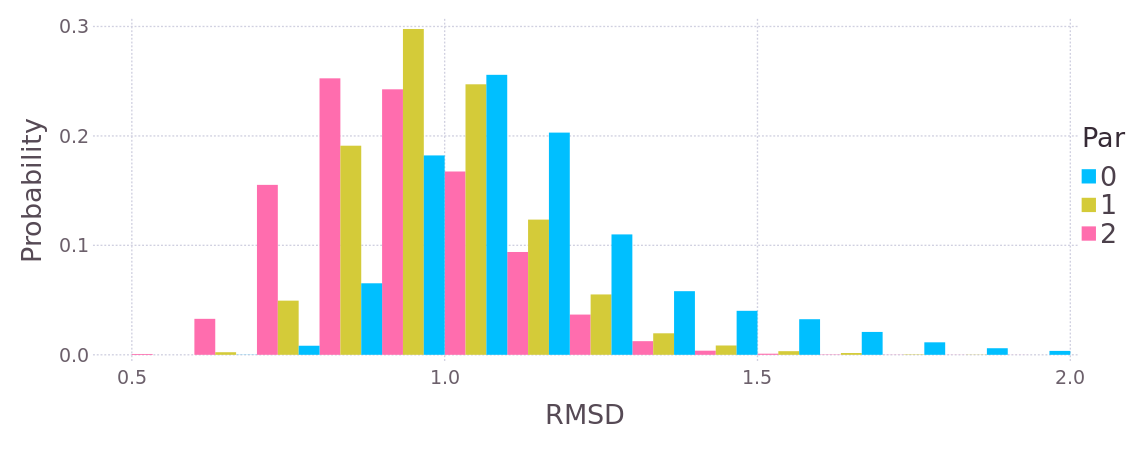

In [166]:
bin_rms = collect(0.5:.1:4.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_vol0, bin_rms, fill(1., length(rmsd_vol0)), true);
his_1, bin_1 = WeightedHist(rmsd_vol1, bin_rms, fill(1., length(rmsd_vol1)), true);
his_2, bin_2 = WeightedHist(rmsd_vol2, bin_rms, fill(1., length(rmsd_vol2)), true);

df_his_rms = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    RMSD = [ bin_0 ; bin_1 ; bin_2 ],
    Par = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

pdf_his_rms = plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [7]:
DataFrame(MEAN = [ mean(rmsd_vol0) ; mean(rmsd_vol1) ; mean(rmsd_vol2) ],
    STD = [ std(rmsd_vol0) ; std(rmsd_vol1) ; std(rmsd_vol2) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN     │ STD      │
├─────┼──────────┼──────────┤
│ 1   │ 1.03955  │ 0.212673 │
│ 2   │ 0.90194  │ 0.143365 │
│ 3   │ 0.838028 │ 0.15236  │

## RMSD
### inter

In [159]:
### Volume 0 vs Volume 1
proto_rmsd_0_1 = readdlm(joinpath(home, pdb, "poblaciones", "inter", "rms2_0_1_4xcp"))[:, 2:end]
rmsd_0_1 = reshape(proto_rmsd_0_1, length(proto_rmsd_0_1))

### Volume 0 vs Volume 2
proto_rmsd_0_2 = readdlm(joinpath(home, pdb, "poblaciones", "inter", "rms2_0_2_4xcp"))[:, 2:end]
rmsd_0_2 = reshape(proto_rmsd_0_2, length(proto_rmsd_0_2))

### Volume 1 vs Volume 2
proto_rmsd_1_2 = readdlm(joinpath(home, pdb, "poblaciones", "inter", "rms2_1_2_4xcp"))[:, 2:end];
rmsd_1_2 = reshape(proto_rmsd_1_2, length(proto_rmsd_1_2));

In [167]:
# Histograma ponderado
bin_rms = collect(.5:.1:4.)
his_0_1, bin_0_1 = WeightedHist(rmsd_0_1, bin_rms, fill(1., length(rmsd_0_1)), true);
his_0_2, bin_0_2 = WeightedHist(rmsd_0_2, bin_rms, fill(1., length(rmsd_0_2)), true);
his_1_2, bin_1_2 = WeightedHist(rmsd_1_2, bin_rms, fill(1., length(rmsd_1_2)), true);

df_his_rms = DataFrame(Probability = [ his_0_1 ; his_0_2 ; his_1_2 ],
    RMSD = [ bin_0_1 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("0_1", length(his_0_1)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

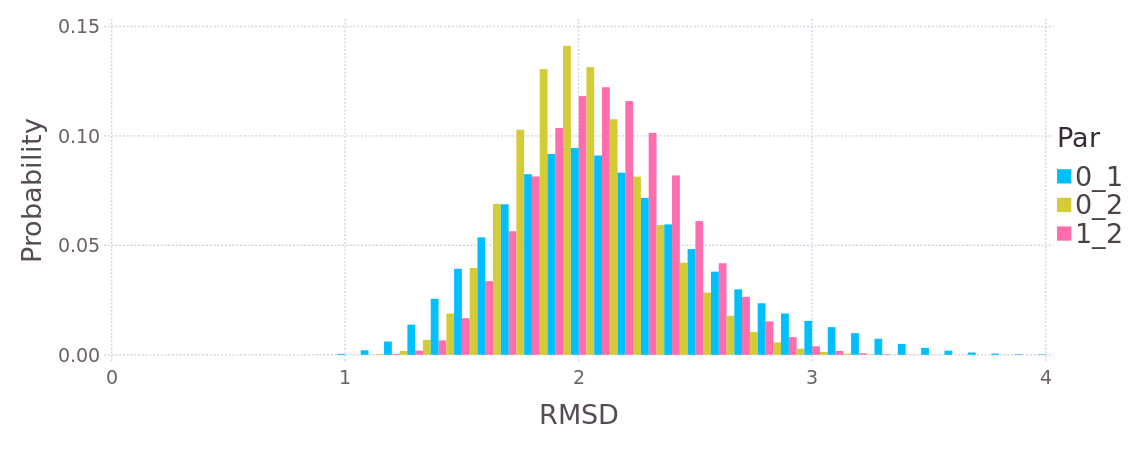

In [168]:
pdf_his_rms = plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [169]:
DataFrame(MEAN = [ mean(rmsd_0_1) ; mean(rmsd_0_2) ; mean(rmsd_1_2) ],
    STD = [ std(rmsd_0_1) ; std(rmsd_0_2) ; std(rmsd_1_2) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD      │
├─────┼─────────┼──────────┤
│ 1   │ 1.97497 │ 0.459858 │
│ 2   │ 1.9174  │ 0.299676 │
│ 3   │ 2.07888 │ 0.317271 │

# RMSDs intra e inter.
##### La misma info de los 2 gráficos anteriorres, pero reordenada

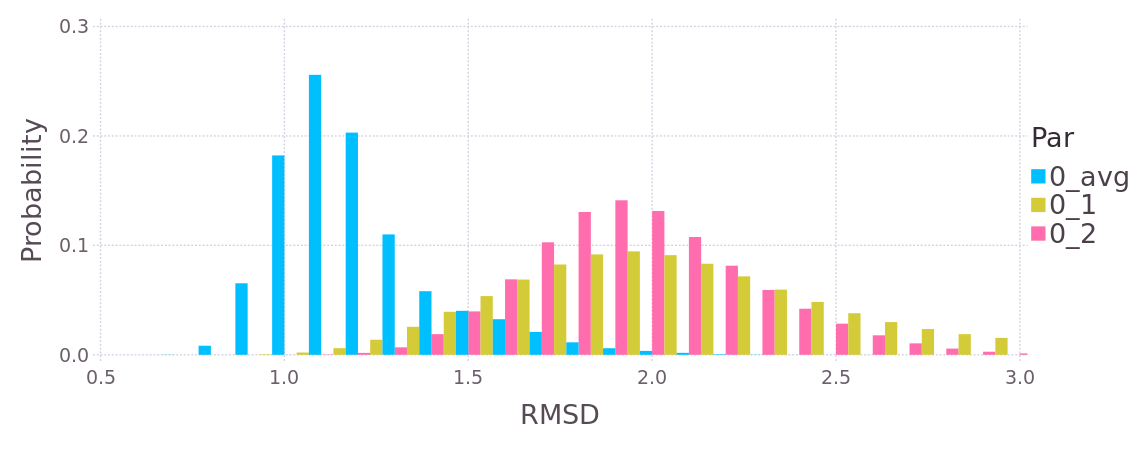

In [170]:
df_his_rms_0 = DataFrame(Probability = [ his_0 ; his_0_1 ; his_0_2 ; ],
    RMSD = [ bin_0 ; bin_0_1 ; bin_0_2 ],
    Par = [ fill("0_avg", length(his_0)) ;
        fill("0_1", length(his_0_1)) ; fill("0_2", length(his_0_2)) ]);

pdf_his_rms_0 = plot(df_his_rms_0, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

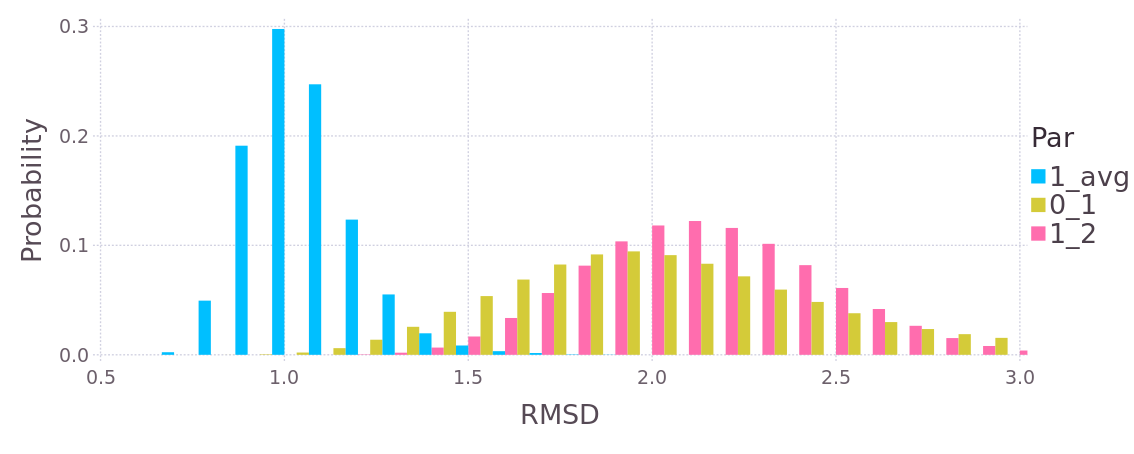

In [171]:
df_his_rms_1 = DataFrame(Probability = [ his_1 ; his_0_1 ; his_1_2 ; ],
    RMSD = [ bin_1 ; bin_0_1 ; bin_1_2 ],
    Par = [ fill("1_avg", length(his_1)) ;
        fill("0_1", length(his_0_1)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_1 = plot(df_his_rms_1, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

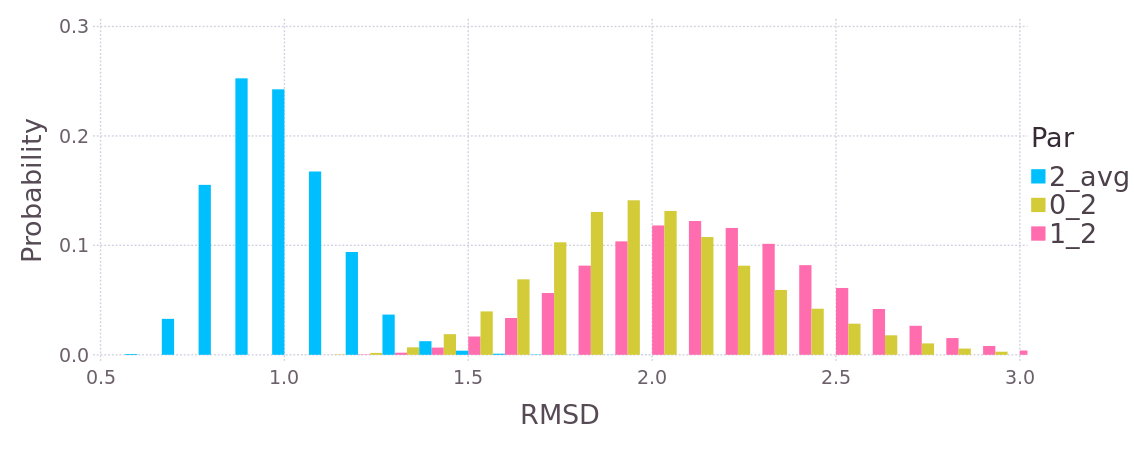

In [173]:
df_his_rms_2 = DataFrame(Probability = [ his_2 ; his_0_2 ; his_1_2 ; ],
    RMSD = [ bin_2 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("2_avg", length(his_2)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_2 = plot(df_his_rms_2, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

# Lig

In [22]:
const c1 = 2427
const cg = 2444

2444

### Distancia

In [23]:
function limito_scope(num, c1, cg, home, pdb)
    in_trj = Trajectory(joinpath(home, pdb, string("poblaciones/vol", num, "_", pdb, ".nc")))
    entrada = Array{Float64, 1}(nsteps(in_trj))
    for i = 0:nsteps(in_trj)-1
        in_frm = read_step(in_trj, i)
        entrada[i+1] = norm(positions(in_frm)[:, c1] - positions(in_frm)[:, cg])
    end
    close(in_trj) 
    return entrada
end

limito_scope (generic function with 3 methods)

In [27]:
# Volume 0
dis_lig_vol0 = limito_scope(0, c1, cg, home, pdb)
# Volume 1
dis_lig_vol1 = limito_scope(1, c1, cg, home, pdb)
# Volume 2
dis_lig_vol2 = limito_scope(2, c1, cg, home, pdb);

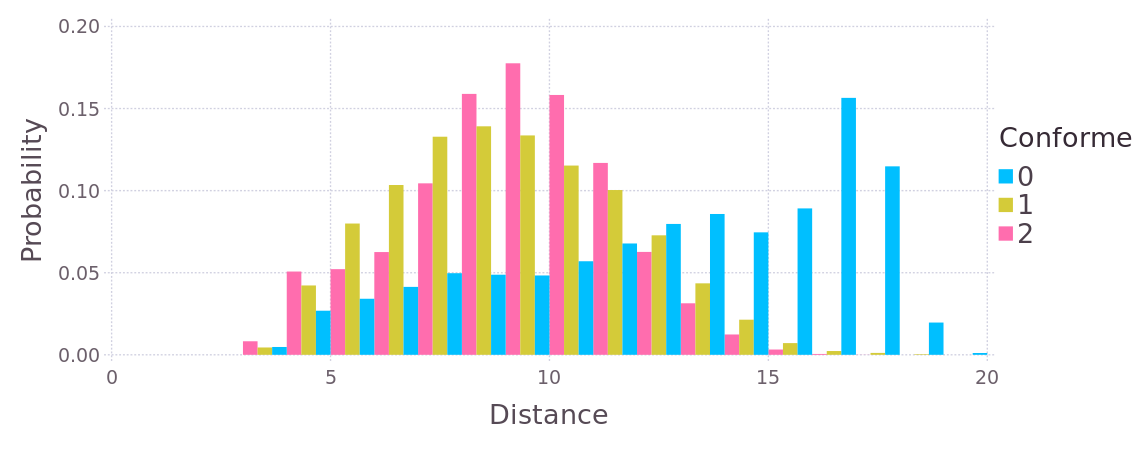

In [36]:
bin_dis = collect(3.:1.:20.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(dis_lig_vol0, bin_dis, fill(1., length(dis_lig_vol0)), true);
his_1, bin_1 = WeightedHist(dis_lig_vol1, bin_dis, fill(1., length(dis_lig_vol1)), true);
his_2, bin_2 = WeightedHist(dis_lig_vol2, bin_dis, fill(1., length(dis_lig_vol2)), true);

df_his_rms_lig = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    Distance = [ bin_0 ; bin_1 ; bin_2 ],
    Conformer = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

pdf_his_rms_lig = plot(df_his_rms_lig, x = "Distance", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

### RMSD
### intra

### Leo el RMSD respecto al avg

In [38]:
rmsd_lig_vol0 = readdlm(joinpath(home, pdb, "poblaciones", "lig", "intra", "rmsd_vol0_lig"))[:, 2]
rmsd_lig_vol1 = readdlm(joinpath(home, pdb, "poblaciones", "lig", "intra", "rmsd_vol1_lig"))[:, 2]
rmsd_lig_vol2 = readdlm(joinpath(home, pdb, "poblaciones", "lig", "intra", "rmsd_vol2_lig"))[:, 2]

42559

### Guardo el frame más similar al avg

In [44]:
function tempor(in_rmsd, num, home, pdb)
    trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol0_", pdb, ".nc")))
    in_top_trj = Trajectory(joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol", num, "_", pdb, "_lig.pdb")))
    in_top_frm = read(in_top_trj)
    in_top = Topology(in_top_frm)
    in_frm = read_step(trj_in, indmin(in_rmsd) - 1)
    set_topology!(in_frm, in_top)
    trj_out = Trajectory(joinpath(home, pdb, "poblaciones", "lig", "intra", string("top_vol", num, "_", pdb, "_lig.pdb")), 'w')
    write(trj_out, in_frm)
    close(trj_out)
    close(trj_in)
end

tempor (generic function with 1 method)

In [45]:
tempor(rmsd_lig_vol0, 0, home, pdb)
tempor(rmsd_lig_vol1, 1, home, pdb)
tempor(rmsd_lig_vol2, 2, home, pdb)

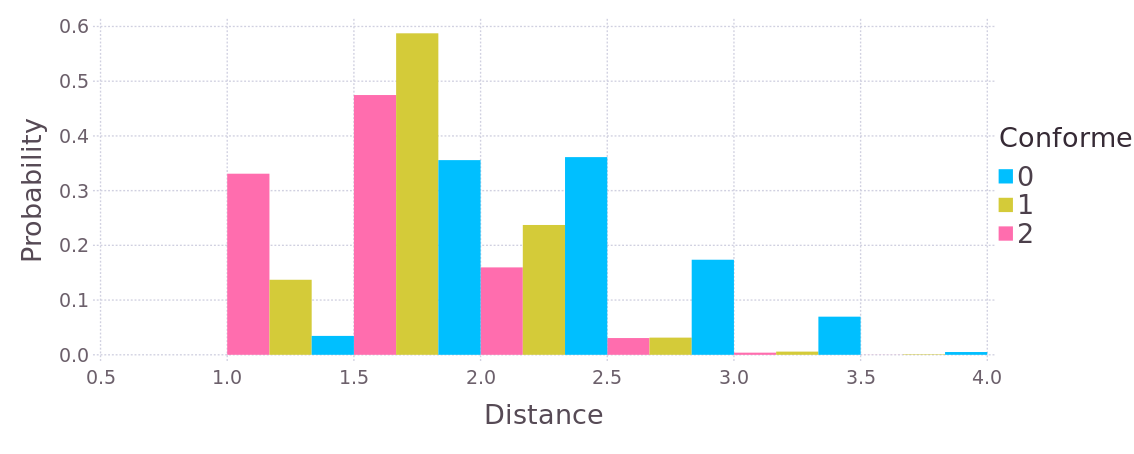

In [137]:
bin_rms = collect(.5:.5:15.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig_vol0, bin_rms, fill(1., length(rmsd_lig_vol0)), true);
his_1, bin_1 = WeightedHist(rmsd_lig_vol1, bin_rms, fill(1., length(rmsd_lig_vol1)), true);
his_2, bin_2 = WeightedHist(rmsd_lig_vol2, bin_rms, fill(1., length(rmsd_lig_vol2)), true);

df_his_rms = DataFrame(Probability = [ his_0 ; his_1 ; his_2 ],
    Distance = [ bin_0 ; bin_1 ; bin_2 ],
    Conformer = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ; fill("2", length(his_2)) ]);

pdf_his_rms = plot(df_his_rms, x = "Distance", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .5, xmax = 4.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

### RMSD cruzado

In [177]:
### Volume 0 vs Volume 1
proto_rmsd_0_1_lig = readdlm(joinpath(home, pdb, "poblaciones", "lig", "inter", "rms2_0_1_4xcp_lig"))[:, 2:end]
rmsd_0_1_lig = reshape(proto_rmsd_0_1_lig, length(proto_rmsd_0_1_lig))

### Volume 0 vs Volume 2
proto_rmsd_0_2_lig = readdlm(joinpath(home, pdb, "poblaciones", "lig", "inter", "rms2_0_2_4xcp_lig"))[:, 2:end]
rmsd_0_2_lig = reshape(proto_rmsd_0_2_lig, length(proto_rmsd_0_2_lig));

### Volume 1 vs Volume 2
proto_rmsd_1_2_lig = readdlm(joinpath(home, pdb, "poblaciones", "lig", "inter", "rms2_1_2_4xcp_lig"))[:, 2:end];
rmsd_1_2_lig = reshape(proto_rmsd_1_2_lig, length(proto_rmsd_1_2_lig))
rmsd_1_2_lig = rmsd_1_2_lig[rmsd_1_2_lig .!= 0.];

In [178]:
bin_rms_lig = collect(.5:.5:15)

# Histograma ponderado
his_0_1, bin_0_1 = WeightedHist(rmsd_0_1_lig, bin_rms_lig, fill(1., length(rmsd_0_1_lig)), true);
his_0_2, bin_0_2 = WeightedHist(rmsd_0_2_lig, bin_rms_lig, fill(1., length(rmsd_0_2_lig)), true);
his_1_2, bin_1_2 = WeightedHist(rmsd_1_2_lig, bin_rms_lig, fill(1., length(rmsd_1_2_lig)), true);

df_his_rms = DataFrame(Probability = [ his_0_1 ; his_0_2 ; his_1_2 ],
    RMSD = [ bin_0_1 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("0_1", length(his_0_1)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

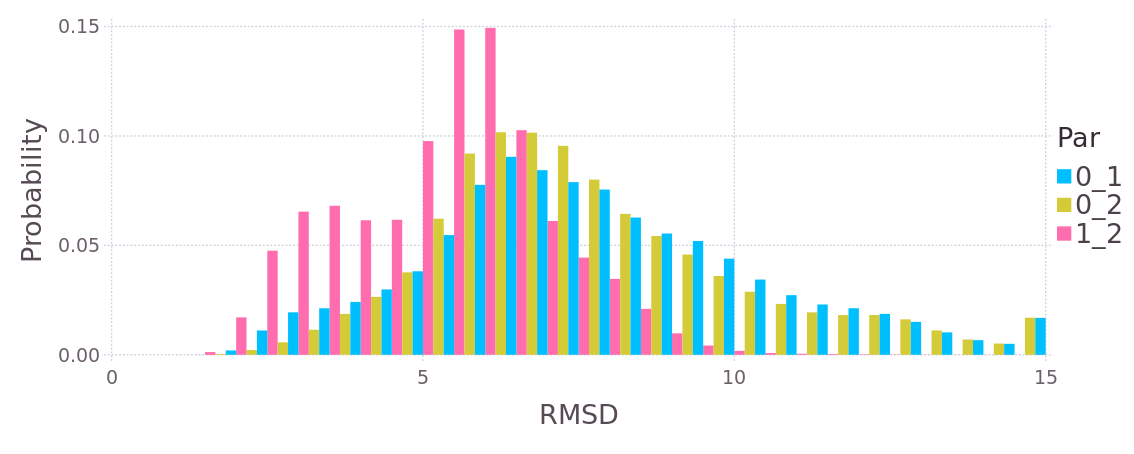

In [179]:
pdf_his_rms = plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 4.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [180]:
DataFrame(MEAN = [ mean(rmsd_0_1_lig) ; mean(rmsd_0_2_lig) ; mean(rmsd_1_2_lig) ],
    STD = [ std(rmsd_0_1_lig) ; std(rmsd_0_2_lig) ; std(rmsd_1_2_lig) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD     │
├─────┼─────────┼─────────┤
│ 1   │ 7.13208 │ 2.74001 │
│ 2   │ 7.18288 │ 2.54555 │
│ 3   │ 5.12005 │ 1.63847 │

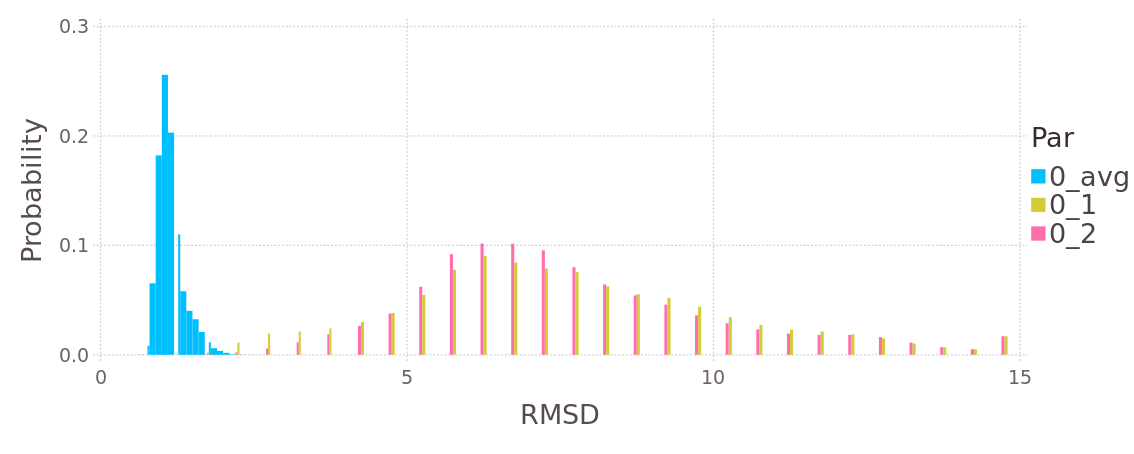

In [181]:
df_his_rms_lig_0 = DataFrame(Probability = [ his_0 ; his_0_1 ; his_0_2 ],
    RMSD = [ bin_0 ; bin_0_1 ; bin_0_2 ],
    Par = [ fill("0_avg", length(his_0)) ;
        fill("0_1", length(his_0_1)) ; fill("0_2", length(his_0_2)) ]);

pdf_his_rms_lig_0 = plot(df_his_rms_lig_0, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

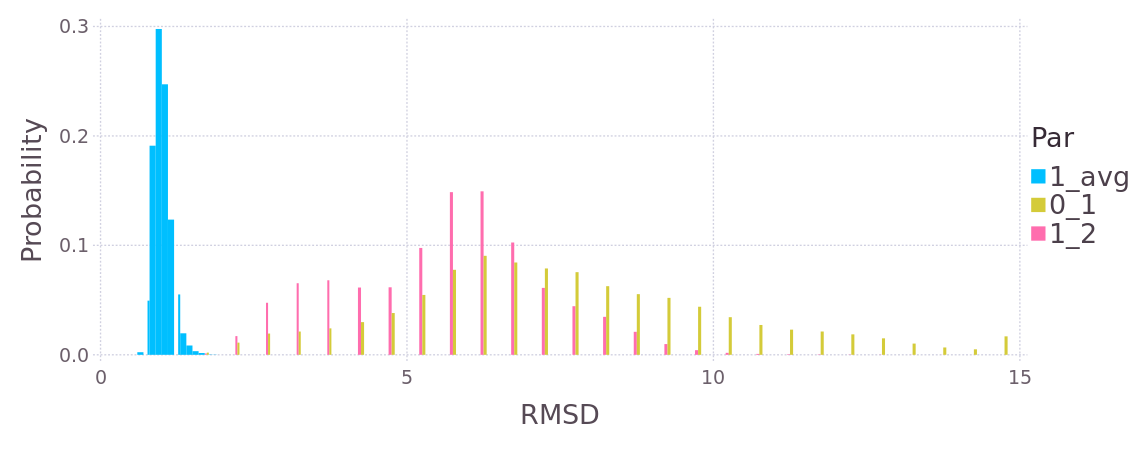

In [182]:
df_his_rms_1_lig = DataFrame(Probability = [ his_1 ; his_0_1 ; his_1_2 ; ],
    RMSD = [ bin_1 ; bin_0_1 ; bin_1_2 ],
    Par = [ fill("1_avg", length(his_1)) ;
        fill("0_1", length(his_0_1)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_1_lig = plot(df_his_rms_1_lig, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

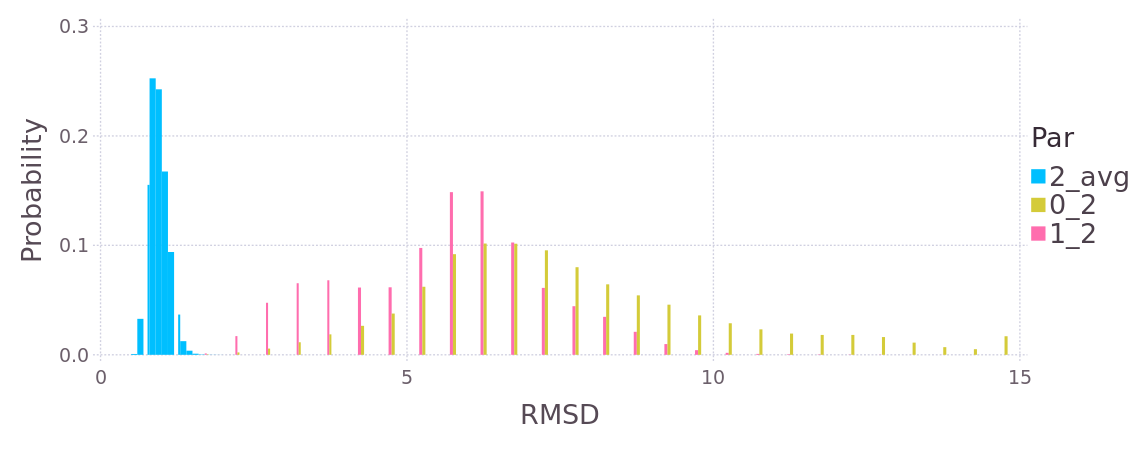

In [183]:
df_his_rms_2_lig = DataFrame(Probability = [ his_2 ; his_0_2 ; his_1_2 ; ],
    RMSD = [ bin_2 ; bin_0_2 ; bin_1_2 ],
    Par = [ fill("2_avg", length(his_2)) ;
        fill("0_2", length(his_0_2)) ; fill("1_2", length(his_1_2)) ]);

pdf_his_rms_2_lig = plot(df_his_rms_2_lig, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = .5, xmax = 3.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))